In [1]:
import numpy as np
import pandas as pd
import polars as pl
import lightgbm as lgb
from glob import glob
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score

In [3]:
INPUT_DIR = "/kaggle/input/child-mind-institute-problematic-internet-use/"

## Preprocess

In [4]:
def preprocess(df):
    df_new = df.copy()
    df_new["Physical-BMI"] = df_new["Physical-BMI"].replace(0, np.nan)
    df_new["Physical-Weight"] = df_new["Physical-Weight"].replace(0, np.nan)
    df_new["Fitness_Endurance-Time_Sec"] += df_new["Fitness_Endurance-Time_Mins"] * 60
    df_new = df_new.drop(["Fitness_Endurance-Max_Stage", "Fitness_Endurance-Time_Mins", "SDS-SDS_Total_T"], axis=1)
    
    return df_new

In [5]:
df = pd.read_csv(INPUT_DIR + "train.csv")
df_test = pd.read_csv(INPUT_DIR + "test.csv")

IS_SUBMIT = len(df_test) != 20

In [6]:
df = preprocess(df)
df_test = preprocess(df_test)

## Missing Value Imputation (IterativeImputer)

In [7]:
drop_cols = list(set(df.columns) - set(df_test.columns))

In [8]:
df_all = pd.concat([df, df_test])

X = df_all.drop(["id", "sii"] + drop_cols, axis=1)
cat_cols = X.columns[X.dtypes=="object"].tolist()
X = X.drop(cat_cols, axis=1)

In [9]:
scaler = StandardScaler().set_output(transform="pandas")
scaler.fit_transform(X.iloc[:len(df)])
X = scaler.transform(X)

imputer = IterativeImputer(random_state=0, verbose=1).set_output(transform="pandas")
imputer.fit(X.iloc[:len(df)])
imputer.set_params(verbose=0)

X = imputer.transform(X)

# drop colums not to impute
X = X.loc[:, ~X.columns.str.contains("BIA-BIA")]
X = X.loc[:, ~X.columns.str.contains("FGC-FGC_S")]
X = X.drop(["CGAS-CGAS_Score", "SDS-SDS_Total_Raw"], axis=1)

for col in X.columns:
    df_all[col] = X[col].values

[IterativeImputer] Completing matrix with shape (3960, 45)
[IterativeImputer] Change: 45.90592008070779, scaled tolerance: 0.044387465901923766 
[IterativeImputer] Change: 150.53927782675683, scaled tolerance: 0.044387465901923766 
[IterativeImputer] Change: 26.765356634770498, scaled tolerance: 0.044387465901923766 
[IterativeImputer] Change: 1.0978731056623885, scaled tolerance: 0.044387465901923766 
[IterativeImputer] Change: 1.4017225734281444, scaled tolerance: 0.044387465901923766 
[IterativeImputer] Change: 1.7203945187131924, scaled tolerance: 0.044387465901923766 
[IterativeImputer] Change: 1.4907226297799365, scaled tolerance: 0.044387465901923766 
[IterativeImputer] Change: 0.8452386301834698, scaled tolerance: 0.044387465901923766 
[IterativeImputer] Change: 0.3651514808840969, scaled tolerance: 0.044387465901923766 
[IterativeImputer] Change: 0.14956579781656876, scaled tolerance: 0.044387465901923766 


/opt/conda/lib/python3.10/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


## Feature from Parquet Files

In [10]:
files = glob(INPUT_DIR + "series_train.parquet/*")
if IS_SUBMIT:
    files += glob(INPUT_DIR + "series_test.parquet/*")

list_df = []
for file in tqdm(files):
    df_series = (
        pl.read_parquet(file)
        .with_columns(
            (
                (pl.col("relative_date_PCIAT") - pl.col("relative_date_PCIAT").min())*24
                + (pl.col("time_of_day") // int(1e9)) / 3600
            ).floor().cast(int).alias("total_hours")
        )
        .filter(pl.col("non-wear_flag") != 1)
        .filter(pl.col("step").count().over("total_hours") == 12 * 60)
        .group_by("total_hours").agg(
            pl.col("enmo").std().alias("enmo_std"),
            pl.col("anglez").std().alias("anglez_std"),
            pl.col("light").std().alias("light_std")
        )
        .with_columns(
            (pl.col("total_hours") % 24).alias("hour"),
            pl.lit(file.split("/")[-1][3:]).alias("id")
        )
    )
    list_df.append(df_series.to_pandas())

df_series = pd.concat(list_df)
df_series["enmo_std"] = np.log(df_series["enmo_std"] + 0.01)
df_series["anglez_std"] = np.log(df_series["anglez_std"] + 1)
df_series["light_std"] = np.log(df_series["light_std"] + 0.01)

df_agg = df_series.groupby("id")[["enmo_std", "anglez_std", "light_std"]].agg(["mean", "std"]).reset_index()
df_agg.columns = [cols[0] + "_" + cols[1] if cols[1] != "" else cols[0] for cols in df_agg.columns]
df_agg

  0%|          | 0/996 [00:00<?, ?it/s]

,id,enmo_std_mean,enmo_std_std,anglez_std_mean,anglez_std_std,light_std_mean,light_std_std
0,00115b9f,-4.000377,NaN,1.989905,NaN,0.051475,NaN
1,001f3379,-3.514671,0.652348,3.236993,0.678888,0.774591,2.945807
2,00f332d1,-3.071176,0.927238,3.249122,0.463244,1.138379,2.939823
3,01085eb3,-2.902040,0.791255,3.389762,0.315061,1.054698,2.185839
4,012cadd8,-2.806918,1.171675,3.337322,0.388409,0.823770,3.350365
...,...,...,...,...,...,...,...
964,fe9c71d8,-3.116904,0.961804,3.037607,0.943554,-0.394200,2.742634
965,fecc07d6,-3.969482,0.981531,1.332831,1.428363,-0.438018,1.795653
966,ff18b749,-2.820076,0.937540,3.258458,0.417267,1.236652,3.341580
967,ffcd4dbd,-3.271800,0.827489,3.183395,0.629553,0.521227,2.665325


In [11]:
df_all = df_all.merge(df_agg, how="left", on="id")
df_all[cat_cols] = df_all[cat_cols].astype("category")

df = df_all.iloc[:len(df)]
df_test = df_all.iloc[len(df):]
    
df = df.dropna(subset=["sii"]).reset_index(drop=True)
df.shape

(2736, 85)

In [12]:
X = df.drop(["id", "sii"] + drop_cols, axis=1)
y = df["sii"].astype(int)

## Custom Functions

In [13]:
a = y.mean()
b = y.var(ddof=0)
y_min = y.min()
y_max = y.max()

In [14]:
# This function can calculate the original Quadratic Weighted Kappa and also supports continuous predictions.
def generalized_qwk(labels, preds):
    preds = preds.clip(y_min, y_max)
    qwk = 1 - ((labels - preds)**2).sum() / ((preds - a)**2 + b).sum()
    
    return qwk


def qwk_metric(preds, data):
    y_true = data.get_label().round()
    y_pred = preds
    qwk = generalized_qwk(y_true, y_pred)
    
    return 'QWK', qwk, True


def qwk_obj(preds, dtrain):
    labels = dtrain.get_label()
    preds = preds.clip(y_min, y_max)
    f = 1/2*np.sum((preds-labels)**2)
    g = 1/2*np.sum((preds-a)**2+b)
    df = preds - labels
    dg = preds - a
    grad = (df/g - f*dg/g**2) * len(labels)
    hess = np.ones(len(labels))
    
    return grad, hess

## Nested CV (10 x 10)

In [15]:
params = {
    "objective": qwk_obj,
    "metric": "None",
    "learning_rate": 0.01,
    "num_leaves": 8,
    "feature_fraction_bynode": 0.6,
    "min_data_in_leaf": 200,
}

In [16]:
n_splits = 10
init_score = a

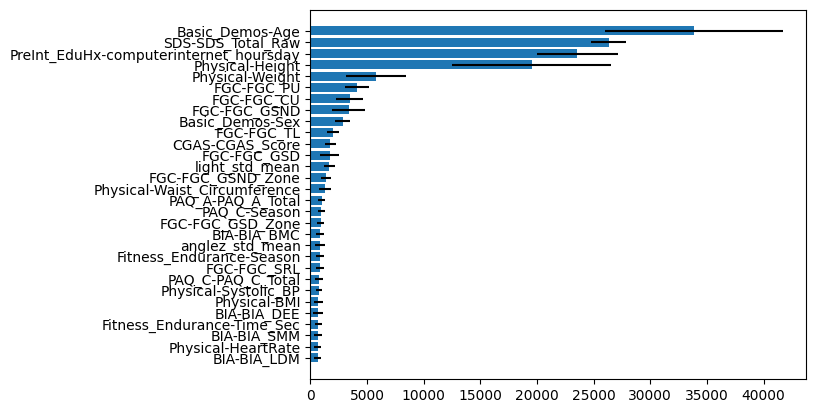

In [17]:
list_target_and_preds_inner_oof = []
preds_outer_oof = np.zeros(len(df))
preds_test = np.zeros(len(df_test))
dfs_importance = []
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=10)
for fold, (idx_train, idx_test) in enumerate(skf.split(X, y)):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_test, y_test = X.iloc[idx_test], y.iloc[idx_test]
    
    folds = [(idx_train, idx_valid) for idx_train, idx_valid in skf.split(X_train, y_train)]
    models = lgb.cv(
        params=params,
        train_set=lgb.Dataset(X_train, y_train, init_score=[init_score]*len(X_train)),
        num_boost_round=10000,
        folds=folds,
        feval=qwk_metric,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
        ],
        return_cvbooster=True
    )["cvbooster"].boosters

    for fold, model in enumerate(models):
        df_importance = pd.DataFrame(model.feature_importance(importance_type="gain"), index=X_train.columns).reset_index()
        df_importance.columns = ["feature", "importance"]
        df_importance["fold"] = fold
        dfs_importance.append(df_importance)

    preds_inner_oof = np.zeros(len(X_train))
    for model, (idx_train, idx_valid) in zip(models, folds):
        preds_inner_oof[idx_valid] = model.predict(X_train.iloc[idx_valid]) + init_score
    list_target_and_preds_inner_oof.append(np.stack([np.array(y_train), preds_inner_oof]).T)

    preds = np.zeros(len(X_test))
    for model in models:
        preds += (model.predict(X_test) + init_score) / n_splits
        preds_test += (model.predict(df_test[X.columns]) + init_score) / n_splits / n_splits
    preds_outer_oof[idx_test] = preds

df_importance = pd.concat(dfs_importance, ignore_index=True)
df_importance = df_importance.groupby("feature")["importance"].agg(["mean", "std"])
df_importance.to_csv("importance.csv")
df_importance = df_importance.reset_index().sort_values("mean").iloc[-30:]
fig, ax = plt.subplots()
ax.barh(
    y=range(len(df_importance)),
    width=df_importance["mean"],
    xerr=df_importance["std"],
    tick_label=df_importance["feature"]
)
plt.show()
plt.close()

## Optimize thresholds

In [18]:
def apply_thresholds(preds, thresholds):
    preds_new = np.zeros(len(preds), dtype=int)
    for threshold in thresholds:
        preds_new += preds > threshold
    
    return preds_new

In [19]:
# iterative grid search 
def optimize_thresholds(y, preds):
    thresholds = np.array([0.5, 1.5, 2.5])
    best_qwk = -np.inf
    while True:
        update_flag = False
        for i in range(len(thresholds)):
            best_threshold = thresholds[i]
            thresholds[i] = 0
            for j in range(300):
                thresholds[i] += 0.01
                qwk_tmp = cohen_kappa_score(y, apply_thresholds(preds, thresholds), weights="quadratic")
                if qwk_tmp > best_qwk:
                    update_flag = True
                    best_qwk = qwk_tmp
                    best_threshold = thresholds[i]
                    print("updated thresholds:", thresholds, "QWK:", best_qwk)
            thresholds[i] = best_threshold
        if not update_flag:
            break
        thresholds = np.sort(thresholds)
    
    return thresholds

In [20]:
preds_all = np.concatenate(list_target_and_preds_inner_oof)
thresholds = optimize_thresholds(preds_all[:, 0], preds_all[:, 1])

updated thresholds: [0.01 1.5  2.5 ] QWK: 0.41991582310647535
updated thresholds: [0.02 1.5  2.5 ] QWK: 0.42236735852907514
updated thresholds: [0.03 1.5  2.5 ] QWK: 0.4239512417641341
updated thresholds: [0.04 1.5  2.5 ] QWK: 0.42587287024931486
updated thresholds: [0.05 1.5  2.5 ] QWK: 0.42709300445318166
updated thresholds: [0.06 1.5  2.5 ] QWK: 0.42855200835438934
updated thresholds: [0.07 1.5  2.5 ] QWK: 0.42998015512322507
updated thresholds: [0.08 1.5  2.5 ] QWK: 0.4309414538284583
updated thresholds: [0.09 1.5  2.5 ] QWK: 0.4322820793598513
updated thresholds: [0.1 1.5 2.5] QWK: 0.4336701688184542
updated thresholds: [0.11 1.5  2.5 ] QWK: 0.43542235183163425
updated thresholds: [0.12 1.5  2.5 ] QWK: 0.4373551355527624
updated thresholds: [0.13 1.5  2.5 ] QWK: 0.43819662075415056
updated thresholds: [0.14 1.5  2.5 ] QWK: 0.43910736099264014
updated thresholds: [0.15 1.5  2.5 ] QWK: 0.44003056664290974
updated thresholds: [0.16 1.5  2.5 ] QWK: 0.4415146067005147
updated threshold

In [21]:
qwks_inner = []
for fold in range(len(list_target_and_preds_inner_oof)):
    labels = list_target_and_preds_inner_oof[fold][:, 0].astype(int)
    preds = list_target_and_preds_inner_oof[fold][:, 1]
    preds = apply_thresholds(preds, thresholds)
    qwks_inner.append(cohen_kappa_score(labels, preds, weights="quadratic"))
    print(f"fold: {fold}\tQWK-inner: {qwks_inner[-1]:.4f}")

preds_outer_oof = preds_outer_oof.clip(y_min, y_max)
preds_outer_oof = apply_thresholds(preds_outer_oof, thresholds)
qwk_outer = cohen_kappa_score(y, preds_outer_oof, weights="quadratic")
print(f"QWK-inner: {np.mean(qwks_inner):.4f} ± {np.std(qwks_inner):.4f}\tQWK-outer: {qwk_outer:.4f}")
print()

fold: 0	QWK-inner: 0.4812
fold: 1	QWK-inner: 0.4889
fold: 2	QWK-inner: 0.4861
fold: 3	QWK-inner: 0.4852
fold: 4	QWK-inner: 0.4942
fold: 5	QWK-inner: 0.5048
fold: 6	QWK-inner: 0.4991
fold: 7	QWK-inner: 0.4772
fold: 8	QWK-inner: 0.4838
fold: 9	QWK-inner: 0.4863
QWK-inner: 0.4887 ± 0.0080	QWK-outer: 0.4884



In [22]:
preds_test = preds_test.clip(y_min, y_max)
preds_test = apply_thresholds(preds_test, thresholds)

In [23]:
df_submission = pd.read_csv(INPUT_DIR + "sample_submission.csv")
df_submission["sii"] = preds_test
df_submission.to_csv("submission.csv", index=False)